# Reward term functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [229]:
max_v = 1.5
dt = 0.2

# action penalty
def r_aug(action):
    # FIXME this is not fine because one action is [0,1] and one is [-0.5, 0.5]
    return 1 - (np.abs(action).mean() * 2)

action = np.random.rand(5000, 2) * 2 - 1
x_a = np.abs(action).sum(axis=1)
y_a = [r_aug(a) for a in action]
# sort by x_a
x_a, y_a = zip(*sorted(zip(x_a, y_a)))

# goal distance
def r_goal_dist(goal_dist_diff):
    return goal_dist_diff / (max_v * dt)
    
goal_dist_diff = (np.random.rand(1000) * 2 - 1) * max_v * dt
x_d = goal_dist_diff
y_d = [r_goal_dist(d) for d in goal_dist_diff]

x_d, y_d = zip(*sorted(zip(x_d, y_d)))

# speed
tau = 0.95
v_ref = 0.8 * max_v

def expectile(x, tau):
    y = np.zeros_like(x)
    pos_x_map = x > 0
    y[pos_x_map] = tau * x[pos_x_map]**2
    y[~pos_x_map] = (1-tau) * x[~pos_x_map]**2
    return y

max_value = max(expectile(np.array(-v_ref), tau), expectile(np.array(max_v - v_ref), tau))
# print(max_value)

def r_speed(vel):
    v_err = vel - v_ref
    return 1 - ((expectile(v_err, tau) * 2) / max_value)
    
vs = np.random.rand(1000) * max_v
x_s = vs
y_s = [r_speed(v) for v in vs]
x_s, y_s = zip(*sorted(zip(x_s, y_s)))

# angular velocity


max_omega = 0.5
tau_omega = 0.5
max_value = expectile(np.array(max_omega), tau_omega)
def r_angular_speed(omega):
    return 1 - ((expectile(np.abs(omega), tau_omega) * 2) / max_value)

omegas = np.random.rand(1000) - 0.5
x_av = omegas
y_av = r_angular_speed(omegas)
x_av, y_av = zip(*sorted(zip(x_av, y_av)))

# cross track error
max_error = 10.

def r_cross_track(ct_err):
    reward = 1 - (2 * np.abs(ct_err) / max_error)
    reward = np.clip(reward, -1, 1)
    return reward
    
ct_errs = (np.random.rand(1000) * 2 - 1) * 12
x_ct = ct_errs
y_ct = [r_cross_track(e) for e in ct_errs]
x_ct, y_ct = zip(*sorted(zip(x_ct, y_ct)))

# obstacle distance
max_obstacle_dist = 1.

def r_obstacle_dist(obstacle_dist):
    rwd = -1 + 2 * (obstacle_dist / max_obstacle_dist)
    return min(1, max(-1, rwd))

obstacle_dist = np.random.rand(1000) * 2
x_o = obstacle_dist
y_o = [r_obstacle_dist(o) for o in obstacle_dist]
x_o, y_o = zip(*sorted(zip(x_o, y_o)))

In [85]:
# TODO we might want to have a similar model for obstacles as for reaching goal, i.e. also a distance based reward

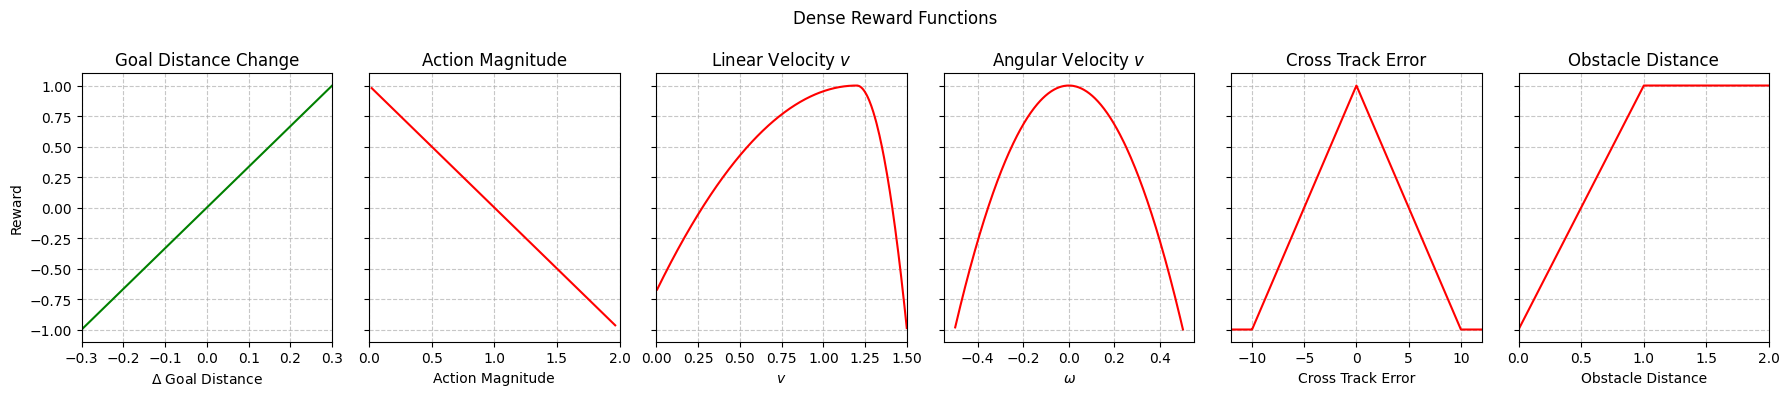

In [248]:
fig, axs = plt.subplots(1, 6, figsize=(18, 4), sharey=True)

axs[0].plot(x_d, y_d, c='g')
axs[0].set_title('Goal Distance Change')
axs[0].set_xlabel('$\Delta$ Goal Distance')
axs[0].set_ylabel('Reward')
axs[0].set_xlim(-.3, .3)

axs[1].plot(x_a, y_a, c='r')
axs[1].set_title('Action Magnitude')
axs[1].set_xlabel('Action Magnitude')
# axs[1].set_ylabel('Reward')
axs[1].set_xlim(0., 2.)

axs[2].plot(x_s, y_s, c='r')
axs[2].set_title('Linear Velocity $v$')
axs[2].set_xlabel('$v$')
# axs[2].set_ylabel('Reward')b
axs[2].set_xlim(0., 1.5)

axs[3].plot(x_av, y_av, c='r')
axs[3].set_title('Angular Velocity $v$')
axs[3].set_xlabel('$\omega$')
# axs[3].set_ylabel('Reward')b
# axs[3].set_xlim(0., 1.5)

axs[4].plot(x_ct, y_ct, c='r')
axs[4].set_title('Cross Track Error')
axs[4].set_xlabel('Cross Track Error')
# axs[4].set_ylabel('Reward')
axs[4].set_xlim(-12., 12.)

axs[5].plot(x_o, y_o, c='r')
axs[5].set_title('Obstacle Distance')
axs[5].set_xlabel('Obstacle Distance')
# axs[5].set_ylabel('Reward')
axs[5].set_xlim(0., 2.)

for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.7)
    # ax.set_ylim(-1., 1.)

fig.suptitle('Dense Reward Functions')

plt.tight_layout()
# plt.savefig('../figures/dense_reward_functions.png', dpi=400)
plt.show()

In [88]:
# NOTE we could control the arrival time by changing the reference velocity online and giving it as input to the policy

In [345]:
from collections import defaultdict

high_speed = 1.5
ideal_speed = v_ref
low_speed = 0.0

low_angular_v = 0.0
high_angular_v = 0.5

high_obstacle_dist = 2.0
low_obstacle_dist = 0.01

high_ct_err = 10.
low_ct_err = .5

high_action_mag = np.array([1.5, -.5])
low_action_mag = np.array([0.1, .1])

max_timesteps = 1000

reach_goal_reward = 100
stop_reward = 0
crash_reward = -100

# scenarios = ['reach_goal', 'stop', 'p_1_crash', 'crash']
# scene_timesteps = [[100, 250], [300], [50, 100, 250], [30, 100, 250]]
scenarios = ['reach_goal', 'stop', 'crash']
scene_timesteps = [[100, 250], [300], [30, 150, 250]]

w = 0.15
b = 0.

results = defaultdict(list)

for i, scene in enumerate(scenarios):
    timesteps = scene_timesteps[i]
    for tsteps in timesteps:
        r_sparse = 0
        if scene == 'reach_goal':
            r_sparse += reach_goal_reward
        elif scene == 'stop':
            r_sparse += stop_reward
        elif scene == 'crash':
            r_sparse += crash_reward
        elif scene == 'p_1_crash':
            r_sparse += crash_reward * 0.01 + reach_goal_reward * 0.99

        r_dense = 0
        r_dense += w * (r_obstacle_dist(high_obstacle_dist) - b)
        r_dense += w * (r_speed(np.array(ideal_speed)) - b)
        # r_dense += w/2 * (r_angular_speed(np.array(low_angular_v)) - b)
        r_dense += w * (r_cross_track(low_ct_err) - b)
        r_dense += w * (r_aug(low_action_mag) - b)

        ideal_reward = r_sparse + r_dense * tsteps
        print(f'{scene} with {tsteps} timesteps: {ideal_reward}')

        r_dense = 0
        r_dense += w * (r_obstacle_dist(low_obstacle_dist) - b)
        r_dense += w * (r_speed(np.array(ideal_speed)) - b)
        # r_dense += w/2 * (r_angular_speed(np.array(low_angular_v)) - b)
        r_dense += w * (r_cross_track(low_ct_err) - b)
        r_dense += w * (r_aug(low_action_mag) - b)

        obs_bad_reward = r_sparse + r_dense * tsteps

        r_dense = 0
        r_dense += w * (r_obstacle_dist(high_obstacle_dist) - b)
        r_dense += w * (r_speed(np.array(high_speed)) - b)
        # r_dense += w/2 * (r_angular_speed(np.array(low_angular_v)) - b)
        r_dense += w * (r_cross_track(low_ct_err) - b)
        r_dense += w * (r_aug(low_action_mag) - b)

        speed_bad_1_reward = r_sparse + r_dense * (tsteps - (25/tsteps))

        r_dense = 0
        r_dense += w * (r_obstacle_dist(high_obstacle_dist) - b)
        r_dense += w * (r_speed(np.array(low_speed)) - b)
        # r_dense += w/2 * (r_angular_speed(np.array(low_angular_v)) - b)
        r_dense += w * (r_cross_track(low_ct_err) - b)
        r_dense += w * (r_aug(low_action_mag) - b)

        speed_bad_2_reward = r_sparse + r_dense * (tsteps + (25/tsteps))

        # r_dense = 0
        # r_dense += w * (r_obstacle_dist(high_obstacle_dist) - b)
        # r_dense += w * (r_speed(np.array(ideal_speed)) - b)
        # # r_dense += w/2 * (r_angular_speed(np.array(high_angular_v)) - b)
        # r_dense += w * (r_cross_track(low_ct_err) - b)
        # r_dense += w * (r_aug(low_action_mag) - b)

        # omega_bad_reward = r_sparse + r_dense * tsteps

        r_dense = 0
        r_dense += w * (r_obstacle_dist(high_obstacle_dist) - b)
        r_dense += w * (r_speed(np.array(ideal_speed)) - b)
        # r_dense += w/2 * (r_angular_speed(np.array(low_angular_v)) - b)
        r_dense += w * (r_cross_track(high_ct_err) - b)
        r_dense += w * (r_aug(low_action_mag) - b)

        x_bad_reward = r_sparse + r_dense * tsteps

        r_dense = 0
        r_dense += w * (r_obstacle_dist(high_obstacle_dist) - b)
        r_dense += w * (r_speed(np.array(ideal_speed)) - b)
        # r_dense += w/2 * (r_angular_speed(np.array(low_angular_v)) - b)
        r_dense += w * (r_cross_track(low_ct_err) - b)
        r_dense += w * (r_aug(high_action_mag) - b)

        aug_bad_reward = r_sparse + r_dense * tsteps

        rewards = [ideal_reward, obs_bad_reward, speed_bad_1_reward, speed_bad_2_reward, x_bad_reward, aug_bad_reward]

        results[scene].append(rewards)

for key in results:
    results[key] = np.array(results[key])

reach_goal with 100 timesteps: 155.5
reach_goal with 250 timesteps: 238.74999999999997
stop with 300 timesteps: 166.49999999999997
crash with 30 timesteps: -83.35
crash with 150 timesteps: -16.750000000000014
crash with 250 timesteps: 38.74999999999997


In [349]:
results['reach_goal'].min(), results['stop'].max(), results['stop'].min(), results['crash'].max()

(125.8, 166.49999999999997, 77.4, 38.74999999999997)

In [348]:
# category_check = results['reach_goal'].min() > results['stop'].max() > results['p_1_crash'].max() > results['crash'].max()
category_check = results['reach_goal'].min() > results['stop'].max() and results['stop'].min() > results['crash'].max()
if category_check:
    print('Category check passed!')
else:
    print('Category check failed!')

inner_check = True
for key, value in results.items():
    inner_cat_check = (value[:,0] > value[:,1:].max(axis=1)).all()
    if not inner_cat_check:
        print(f'Inner check failed for {key}')
        inner_check = False

if inner_check:
    print('Inner check passed!')

if inner_check and category_check:
    print('All checks passed!')
else:
    failed_checks = int(not inner_check) + int(not category_check)
    print(f'Number of checks that failed: {failed_checks}/2')

Category check failed!
Inner check passed!
Number of checks that failed: 1/2


In [219]:
# an alternative to this could be to desired angular vel of 0 

# TODO how could we modify this such that colliding in 1% of cases is worse than not driving at all?